<a href="https://colab.research.google.com/github/beifa/kaggle_ashrae/blob/master/from_scratch_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import gc
import os
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns 
from lightgbm import LGBMRegressor
from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.metrics import mean_squared_log_error
from IPython.display import HTML
import matplotlib.pyplot as plt

pd.set_option("max_columns", 500)
path = '/content/drive/My Drive/ASHRAE/data/'

#Data load

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def input_file(file):
    path = f"/content/drive/My Drive/ASHRAE/data/{file}"
    if not os.path.exists(path): return path + ".gz"
    return path

In [0]:
!ls '/content/drive/My Drive/ASHRAE/data/'

building_metadata.csv	   sample_submission.csv  train_full_fill.pkl.gz
data_test_before_fake.pkl  test.csv		  weather_test.csv
metadata_fillNAN.pkl.gz    train.csv		  weather_train.csv


In [0]:
def compress_dataframe(df):
  """
  не знаю надо будет попробывать, что такой подход проще чем указывать
  и проверять данные для уменьшения размера(по памяти).
  А тут пандас само это делает downcast: {"целое число", "подписано", "без знака", "плавать"}, начинает с мин и тд.
  
  train - mem used - 616 after compres -173
  """
  result = df.copy()
  for col in result.columns:
    col_data = result[col]
    dn = col_data.dtype.name    
    if dn == "object":
      """
      make category and return cat int      
      """
      result[col] = pd.to_numeric(col_data.astype("category").cat.codes, downcast="integer")
    elif dn == "bool":
      result[col] = col_data.astype("int8")
    elif dn.startswith("int") or (col_data.round() == col_data).all():
      result[col] = pd.to_numeric(col_data, downcast="integer")
    else:
      result[col] = pd.to_numeric(col_data, downcast='float')
  return result

#Weather

In [0]:
def fill_by_each_id(df):
  """
  идею подглядел, можно время преобразовать в часы и сделать после смещение для выравнивания по зонам
  но можно сделать и иначе просто сделать из времени категории(на выходе одно и тоже)
  """
  offsets = [-5, 0, -7, -5, -8, 0, -5, -5, -5, -6, -7, -5, 0, -6, -5, -5]#на сколько время отклоняется для каждого сайта  
  df.timestamp = df.timestamp.astype("datetime64[ns]")
  df.timestamp = (df.timestamp- pd.to_datetime('2016-01-01')).dt.total_seconds() // 3600
  dict_offset = {site:offset for site, offset in enumerate(offsets)} #{0: -5, 1: 0,...}
  df.timestamp = df.timestamp - df.site_id.map(dict_offset)
  box = []
  for iid in df.site_id.unique():
    """
    макс 8784 нужно сделать для всех одинаково если не использовать реиндекс значения будут разные а нам нужно чтоб было одинаково
    после этого у нас появляется  пропущенные значения site_id мы можем сразу заполнить
    """
    site = df[df.site_id == iid].set_index(['timestamp']).reindex(range(8784))
    site.site_id = iid #fill site id
    for col in [c for c in site.columns if c  != 'site_id']: # all col without site_id
      site[f'mark_not_fill_{col}'] = ~site[col].isna() # return not na
      site[col] = site[col].interpolate(limit_direction='both', method='linear')
      site[col] = site[col].fillna(df[col].median())
    box.append(site)# after we concat site_id : 0, 1, 15 
  df = pd.concat(box).reset_index()
  return compress_dataframe(df).set_index(["site_id", "timestamp"])

In [0]:
weather_test.isnull().sum()

air_temperature                     0
cloud_coverage                      0
dew_temperature                     0
precip_depth_1_hr                   0
sea_level_pressure                  0
wind_direction                      0
wind_speed                          0
mark_not_fill_air_temperature       0
mark_not_fill_cloud_coverage        0
mark_not_fill_dew_temperature       0
mark_not_fill_precip_depth_1_hr     0
mark_not_fill_sea_level_pressure    0
mark_not_fill_wind_direction        0
mark_not_fill_wind_speed            0
dtype: int64

In [0]:
def fill_by_each_id_test(df):
  """
  df = weather

  df == 1 year train but test split for bool by two years

  year = '2016-01-01'(train), count = 8784
  year = '2017-01-01'(test), count = 8599
  year = '2018-01-01'(test), count = 3079 not all year
  ======================ps
  карочь не хватает памяти дропается, + много дубликатов но и вот дропнуть их не могу по памяти не получается такой подход и вот
  темным вечерком пришла мысля такая timestamp - 2016 на тесте начинается с 8789 и кончается 26308 и вот оно решение
  ======================

  идею подглядел, можно время преобразовать в часы и сделать после смещение для выравнивания по зонам
  но можно сделать и иначе просто сделать из времени категории(на выходе одно и тоже)
  """
  offsets = [-5, 0, -7, -5, -8, 0, -5, -5, -5, -6, -7, -5, 0, -6, -5, -5]#на сколько время отклоняется для каждого сайта  
  df.timestamp = df.timestamp.astype("datetime64[ns]")
  df.timestamp = (df.timestamp- pd.to_datetime('2016-01-01')).dt.total_seconds() // 3600
  dict_offset = {site:offset for site, offset in enumerate(offsets)} #{0: -5, 1: 0,...}
  df.timestamp = df.timestamp - df.site_id.map(dict_offset)
  #return df 
  box = []
  for iid in df.site_id.unique():
    site = df[df.site_id == iid].set_index(['timestamp']).reindex(range(8789, 26308))
    site.site_id = iid #fill site id
    for col in [c for c in site.columns if c  != 'site_id']: # all col without site_id
      site[f'mark_not_fill_{col}'] = ~site[col].isna() # return not na
      site[col] = site[col].interpolate(limit_direction='both', method='linear')
      site[col] = site[col].fillna(df[col].median())
    box.append(site)# after we concat site_id : 0, 1, 15 
  df = pd.concat(box).reset_index()
  return compress_dataframe(df).set_index(["site_id", "timestamp"])

#Bad data

Read as {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}. Not every building has all meter types.

In [0]:
def drop_0(df):
  """идея тут проста электричество не может быть 0, для комерческих построек
   там полюбому доже если никто не работает или ночь или хз что тратится энергия,
   от общего числа данных эти значения составляют 0,02%.
   Альтернатива добавить сюда другие счетчики дабы исключить все"""
  df = df.reindex(df[(df.meter_reading > 0) & (df.meter >= 0)].index) #0.9073027933181969 
  return  df

#train = compress_dataframe(pd.read_csv(input_file('train.csv')))
#а надо ди дропав тесте вот плин
#train_new = drop_0(train)

In [0]:
mask = train_new.meter == 1
train_new.loc[mask,'meter_reading'].quantile([.1, .3, .7, .9])

0.1       0.000000
0.3      23.949699
0.7     359.351990
0.9    1277.459961
Name: meter_reading, dtype: float64

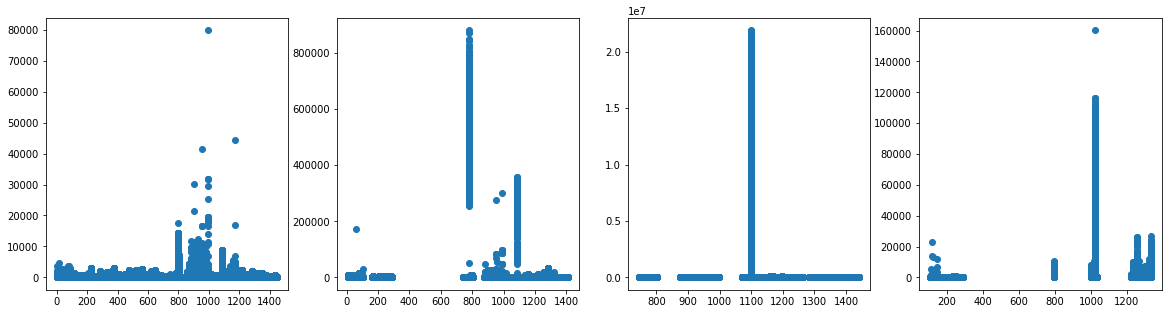

In [0]:
plt.figure(figsize=(20, 5))
for n in range(4):
  num = n+1
  plt.subplot(140 + num)
  mask = train_new.meter == (num -1)
  plt.scatter(x = train_new.loc[mask, 'building_id'], y = train_new.loc[mask, 'meter_reading'])

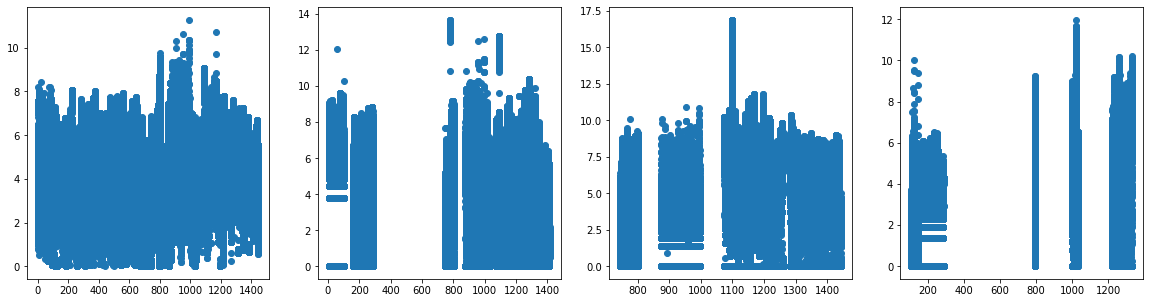

In [0]:
plt.figure(figsize=(20, 5))
for n in range(4):
  num = n+1
  plt.subplot(140 + num)
  mask = train_new.meter == (num -1)
  y = np.log1p(train_new.loc[mask, 'meter_reading'].values)
  plt.scatter(x = train_new.loc[mask, 'building_id'], y = y)

In [0]:
idx = train_new.loc[mask,'meter_reading'][(train_new.loc[mask,'meter_reading'] > 1300)].index

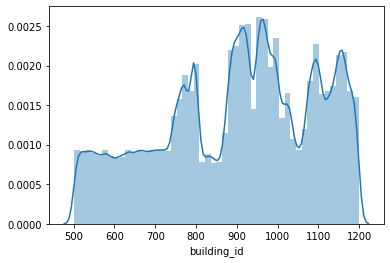

In [0]:
sns.distplot(train_new[(train_new.building_id > 500) & (train_new.building_id < 1200)].building_id)

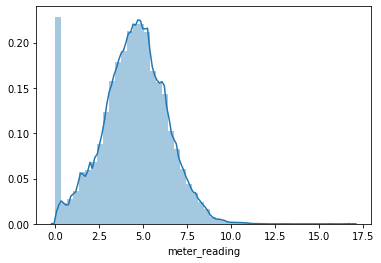

In [0]:
sns.distplot(np.log1p(train_new.meter_reading))

In [0]:
np.log1p(train_new.meter_reading).skew(), np.log1p(train_new.meter_reading).kurt()

(-0.26242822, 0.03970269)

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


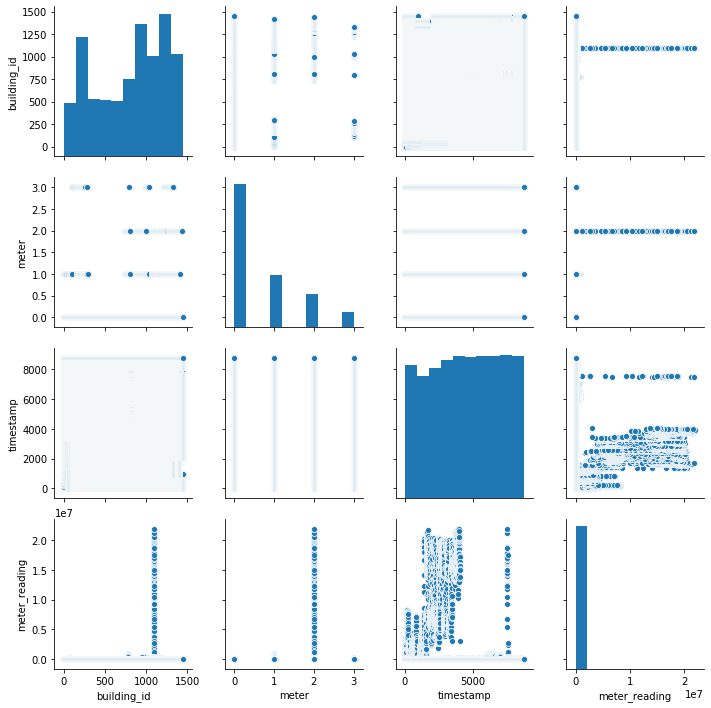

In [0]:
#sns.pairplot(train_new, size = 2.5)

In [0]:
def rand_sample(df, f = 0.25):
  #вернет выборку рандомную, f - коеф. размера выборки
  np.random.seed(0)
  sample_idx = np.random.choice(df.index, int(df.index.shape[0] * f))
  sample = df.loc[sample_idx]
  return sample

In [0]:
new

,building_id,meter,timestamp,meter_reading,target
45,46,0,0,3.993413,53.239700
72,74,0,0,3.784219,43.001301
91,93,0,0,3.978196,52.420601
103,105,0,0,3.190624,23.303600
104,106,0,0,0.318163,0.374600
...,...,...,...,...,...
20216094,1443,0,8783,4.188897,64.949997
20216095,1444,0,8783,2.277267,8.750000
20216096,1445,0,8783,1.762159,4.825000
20216098,1447,0,8783,5.078761,159.574997


In [0]:
def add_divide_by10(data, div_log = True, boxcox = False):
  #есть выброрсы как мы знаем, поробуем y / 10 if > mean
  #на графика есть улучьшение
  #но после лог еще лучше, нужно проверять
  df = data.copy()
  df['target'] = df.meter_reading
  for m in range(4):
    temp = df[df.meter == m]
    mask = temp.meter_reading > temp.meter_reading.mean()      
    df.loc[mask.index].meter_reading[mask] = temp.loc[mask, 'meter_reading'] / 10
    df.loc[mask.index].meter_reading[~mask] = temp.loc[~mask, 'meter_reading']

  if div_log:
    print('log')
    df['meter_reading'] = np.log1p(df['meter_reading'])
    
  if boxcox:
    print('boxcox')
    df['meter_reading'] = boxcox1p(df['meter_reading'], 0.05)    

  #make return X, y
  # X = df.drop('meter_reading', axis = 'columns')
  # y = df['meter_reading']

  return df 

In [0]:
new = add_divide_by10(train_new, div_log = False)

In [0]:
new.isnull().sum()

building_id      0
meter            0
timestamp        0
meter_reading    0
target           0
dtype: int64

(0, 2000)

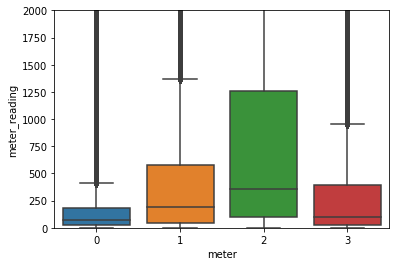

In [0]:
sample = rand_sample(new, f = 0.25)
sns.boxplot(sample['meter'], sample['meter_reading'])
plt.ylim(0, 2000)

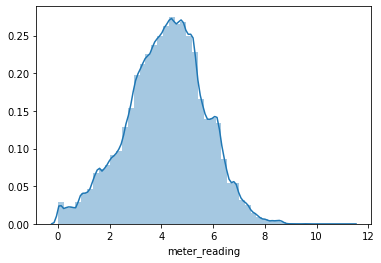

In [0]:
sns.distplot(sample[sample.meter == 0].meter_reading)

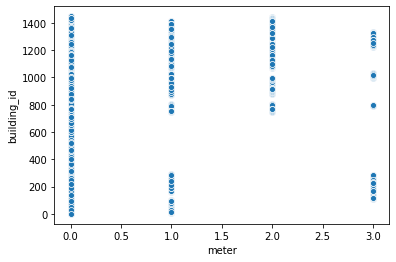

In [0]:
sns.scatterplot(x = sample.meter, y= sample.building_id)

Read as {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}. Not every building has all meter types.


#StandardScaler

In [0]:
from sklearn.preprocessing import StandardScaler
#meter_scaled = StandardScaler().fit_transform(train_new['meter_reading']);

# Statistics

In [0]:
from scipy import stats
from scipy.stats import norm, skew #for some statistics
from scipy.special import boxcox1p

In [0]:
(mu, sigma) = norm.fit(new.meter_reading)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))


 mu = 2333.42 and sigma = 160871.72



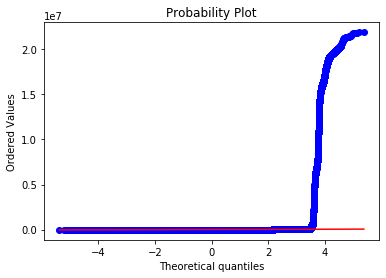

In [0]:
#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(new.meter_reading, plot=plt)
plt.show()

log


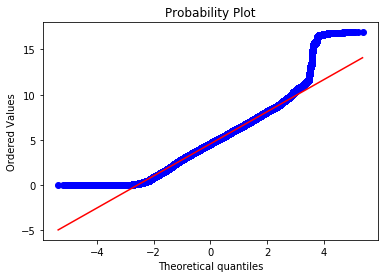

In [0]:
#Get also the QQ-plot
fig = plt.figure()
new_log = add_divide_by10(train_new, div_log = True)
res = stats.probplot(new_log.meter_reading, plot=plt)
plt.show()

In [0]:
skew(new_log.target), skew(new_log.meter_reading)

(99.83386993408203, 0.03800378739833832)

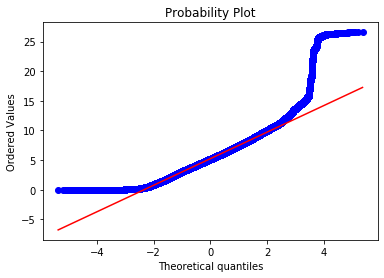

In [0]:
res = stats.probplot(boxcox1p(new.meter_reading, 0.05), plot=plt)
plt.show()

#Fill metadata

In [0]:
metadata = pd.read_csv(input_file("building_metadata.csv"))

In [0]:
metadata.isnull().sum()

site_id           0
building_id       0
primary_use       0
square_feet       0
year_built      774
floor_count    1094
dtype: int64

In [0]:
metadata.groupby(['primary_use'])['floor_count'].size()

primary_use
Education                        549
Entertainment/public assembly    184
Food sales and service             5
Healthcare                        23
Lodging/residential              147
Manufacturing/industrial          12
Office                           279
Other                             25
Parking                           22
Public services                  156
Religious worship                  3
Retail                            11
Services                          10
Technology/science                 6
Utility                            4
Warehouse/storage                 13
Name: floor_count, dtype: int64

Food sales and service (2005 - 2012 )
- сюда входят рестораны, ночьные клубы, фастфуд, супермаркеты и тд.
Я думаю что в большенстве своем это одноэтажные здания и мы установим значение на 2.

Religious worship (< 1980)

- церкви, храмы, мечети, синагоги, дома собраний или любые другие здания, которые в основном служат местом религиозного поклонения значение 1

Services (2003-2007-2012)
- Data Center, Personal Services (Health/Beauty, Dry Cleaning, etc),
  Repair Services (Vehicle, Shoe, Locksmith, etc) значение 1.5

Радует не большое количество зданий 5, 3, 10


In [0]:
m = metadata.primary_use == 'Food sales and service'
metadata.loc[m, 'year_built'] = [2012, np.nan, 2005, np.nan, 2009]
metadata.loc[m, 'floor_count'] = [2, np.nan, 1, np.nan, 2]
#
m2 =  metadata.primary_use == 'Religious worship'
metadata.loc[m2, 'year_built'] = [1970, 1980, 1930]
metadata.loc[m2, 'floor_count'] = [1, 2, 2]
#
m3 =  metadata.primary_use == 'Services'
metadata.loc[m3, 'year_built'] = [2003, 2007, np.nan, 2005, np.nan, 2012, np.nan, np.nan, 2009, np.nan]
metadata.loc[m3, 'floor_count'] = [3, 1, np.nan, 2, np.nan, 1, np.nan, 3, 2, np.nan]

In [0]:
metadata['year_built'] = metadata['year_built'].interpolate()
metadata['floor_count'] = metadata['floor_count'].interpolate(method = 'pad')

In [0]:
#вначале много пропусков  мином заполним
m = metadata['floor_count'].isnull()
metadata.loc[m, 'floor_count'] = int(metadata['floor_count'].mean() )

In [0]:
metadata['year_built'] = metadata['year_built'].astype('int')

In [0]:
#metadata.to_pickle(path + 'metadata_fillNAN.pkl.gz')

In [0]:
metadata.isnull().sum()

site_id        0
building_id    0
primary_use    0
square_feet    0
year_built     0
floor_count    0
dtype: int64

#? need make by primary meter
metadata.groupby(['primary_use'])['floor_count'].size()

#Merge data

In [0]:
def read_building_metadata():
  return compress_dataframe(pd.read_pickle(
        input_file("metadata_fillNAN.pkl.gz")).set_index("building_id"))

In [0]:
def read_test():
    df = pd.read_csv(input_file("test.csv"), parse_dates=["timestamp"])
    df.timestamp = (df.timestamp - pd.to_datetime("2016-01-01")).dt.total_seconds() // 3600
    return compress_dataframe(df).set_index("row_id")

In [0]:
def mergeall(name, weather, train = True, save = False):  
  weather = pd.read_csv(input_file(weather))  
  #train --> metadata-->weather
  if train:
    weather = fill_by_each_id(weather)
    data = drop_0(compress_dataframe(pd.read_csv(input_file(name))))
  else:
    weather = fill_by_each_id_test(weather)
    data = read_test()

  df = data.join(read_building_metadata(), on="building_id") \
              .join(weather, on=["site_id", "timestamp"]).fillna(-9999)#.to_pickle(path + 'data_test_before_fake.pkl')
  print('Ends')
  del data
  del weather
  gc.collect()

  # print(df.info())
  # if save:
  #   #Save but crush memory
  #   df.to_pickle(path + 'data_test_before_fake.pkl')
  #   return print('Saved not return df pls load instance')

  return df

In [0]:
#тут нужен другой трайн уже скоректированный, не забыть что тест надо корректировать
#data_train = mergeall('train.csv', 'weather_train.csv')

In [0]:
data_train.isnull().sum()

building_id                         0
meter                               0
timestamp                           0
meter_reading                       0
site_id                             0
primary_use                         0
square_feet                         0
year_built                          0
floor_count                         0
air_temperature                     0
cloud_coverage                      0
dew_temperature                     0
precip_depth_1_hr                   0
sea_level_pressure                  0
wind_direction                      0
wind_speed                          0
mark_not_fill_air_temperature       0
mark_not_fill_cloud_coverage        0
mark_not_fill_dew_temperature       0
mark_not_fill_precip_depth_1_hr     0
mark_not_fill_sea_level_pressure    0
mark_not_fill_wind_direction        0
mark_not_fill_wind_speed            0
dtype: int64

In [0]:
#data_train.to_pickle(path + 'data_train_before_fake.pkl.gz')#1g

In [0]:
data_test = mergeall('in metod name file', 'weather_test.csv', train=False, save = True)

Ends


In [0]:
data_test.isnull().sum()

building_id                         0
meter                               0
timestamp                           0
site_id                             0
primary_use                         0
square_feet                         0
year_built                          0
floor_count                         0
air_temperature                     0
cloud_coverage                      0
dew_temperature                     0
precip_depth_1_hr                   0
sea_level_pressure                  0
wind_direction                      0
wind_speed                          0
mark_not_fill_air_temperature       0
mark_not_fill_cloud_coverage        0
mark_not_fill_dew_temperature       0
mark_not_fill_precip_depth_1_hr     0
mark_not_fill_sea_level_pressure    0
mark_not_fill_wind_direction        0
mark_not_fill_wind_speed            0
dtype: int64

In [0]:
#save test
#data_test.to_pickle(path + 'data_test.pkl.gz')

Wow correct fill offeset -1

In [0]:
data_test.shape

(41697600, 22)

In [0]:
data_test.info(memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41697600 entries, 0 to 41697599
Data columns (total 22 columns):
building_id                         int16
meter                               int8
timestamp                           int16
site_id                             int8
primary_use                         int8
square_feet                         int32
year_built                          int16
floor_count                         int8
air_temperature                     float32
cloud_coverage                      float32
dew_temperature                     float32
precip_depth_1_hr                   float32
sea_level_pressure                  float32
wind_direction                      float32
wind_speed                          float32
mark_not_fill_air_temperature       float64
mark_not_fill_cloud_coverage        float64
mark_not_fill_dew_temperature       float64
mark_not_fill_precip_depth_1_hr     float64
mark_not_fill_sea_level_pressure    float64
mark_not_fill_wind_direct

In [0]:
#data_test.to_csv(path + 'data_test_before_fake.csv')# bad 4g

#load saved merge

In [0]:
#train = pd.read_pickle(path + 'data_train_before_fake.pkl.gz')
test = pd.read_pickle(path + 'data_test.pkl.gz')

#Fake

In [0]:
def drop_fake_site(df):
  #141days, after merge data
  df = df[(df.timestamp >= 3378) | (df.site_id != 0) | (df.meter != 0)]
  return df

In [0]:
train_new = drop_fake_site(train)

In [0]:
#correct
train.shape[0] - train_new.shape[0]

3377

# Time features add

In [0]:
def make_time(idx, namefile, savename):
  """
  поскольку компрес меняет тиме мне нужно его грузить отдельно и потом добавить ща посмотрим как  сделать это

  name = file name to load
  idx file train after drop 0 meter  
  meybe saved ?
  """
  temp = pd.read_csv(input_file(namefile))
  time = temp.loc[idx.index].timestamp
  del temp
  gc.collect()

  time = pd.to_datetime(time)
  df = pd.DataFrame(time, columns=['timestamp'])
  col = 'timestamp'

  df['hour'] = df[col].dt.hour.astype(np.uint8)
  df['month'] = df[col].dt.month.astype(np.uint8) - 1
  df['weekday'] = df[col].dt.weekday.astype(np.uint8)
  df['dayofyear'] = df[col].dt.dayofyear.astype(np.uint16) - 1
  df['weekofyear'] = df[col].dt.weekofyear.astype(np.uint8) - 1
  df['quarter'] = df[col].dt.quarter.astype(np.uint8) - 1
  df['monthday'] = df[col].dt.day.astype(np.uint8) - 1

  #holiday
  from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
  dates_range = pd.date_range(start='2015-12-31', end='2019-01-01')
  us_holidays = calendar().holidays(start=dates_range.min(), end=dates_range.max())
  df['holiday'] = df[col].isin(us_holidays).astype(np.int8)


  del time
  gc.collect()
  df.drop('timestamp', axis = 'columns', inplace=True) #нам не нужно время по умолчанию дропаем, только  признаки
  #df.to_pickle(path + savename)
  return df

"""
у нас теперь есть время отдельно от трайна

"""
#temp = make_time(train_new, 'train.csv', savename = 'time_train.pkl.gz')
#temp  = make_time(data_test, 'test.csv', savename = 'time_test.pkl.gz') #saved

'\nу нас теперь есть время отдельно от трайна\n\n'

In [0]:
temp.isnull().sum()

hour          0
month         0
weekday       0
dayofyear     0
weekofyear    0
quarter       0
monthday      0
holiday       0
dtype: int64

In [0]:
temp.shape

(41697600, 8)

In [0]:
#save test
#temp.to_pickle(path + 'test_addTime.pkl.gz')

In [0]:
#correct
temp.shape[0] -train_new.shape[0]

0

In [0]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

dates_range = pd.date_range(start='2015-12-31', end='2019-01-01')
us_holidays = calendar().holidays(start=dates_range.min(), end=dates_range.max())

pd.DataFrame(time, columns=['timestamp']).timestamp.astype('datetime64').isin(us_holidays).astype(np.int8)

#add Roll

In [0]:
def roll_features(df,savename, win = 24):
  #after merge and add time
  #df = datamerge
  for col in ['air_temperature', 'dew_temperature']:
    df['rolling_back_'+ col] = df.groupby(by='site_id')[col]\
          .rolling(window=win, min_periods=1).mean().interpolate().values.astype(np.int16)
    # reversed rolling
    df['rolling_forw_'+ col] = df.iloc[::-1].groupby(by='site_id')[col]\
          .rolling(window=win, min_periods=1).mean().interpolate().values.astype(np.int16)

    # rolling mean for same hour of the day
    df['rolling_back_h_'+ col] = df.groupby(by=['site_id', 'hour'])[col]\
          .rolling(window=3, min_periods=1).mean().interpolate().values.astype(np.int16)

    df['rolling_back_h_f_' + col] = df.iloc[::-1].groupby(by=['site_id', 'hour'])[col]\
          .rolling(window=3, min_periods=1).mean().interpolate().values.astype(np.int16)
  
  #df.to_pickle(path + savename)
  return df
  
# roll_features(,savename = 'roll_train.pkl.gz', win = 24)
# roll_features(,savename = 'roll_test.pkl.gz', win = 24)

In [0]:
#correct
temp_roll = roll_features(pd.concat([train_new, temp], axis = 'columns'),savename = 'roll_train.pkl.gz', win = 24)

In [0]:
#test
time_test = pd.read_pickle(path + 'test_addTime.pkl.gz')
temp_roll_test = roll_features(pd.concat([test, time_test], axis = 'columns'),savename = 'roll_train.pkl.gz', win = 24)

In [0]:
del test
del time_test
gc.collect()

177

In [0]:
temp_roll_test.isnull().sum()

building_id                         0
meter                               0
timestamp                           0
site_id                             0
primary_use                         0
square_feet                         0
year_built                          0
floor_count                         0
air_temperature                     0
cloud_coverage                      0
dew_temperature                     0
precip_depth_1_hr                   0
sea_level_pressure                  0
wind_direction                      0
wind_speed                          0
mark_not_fill_air_temperature       0
mark_not_fill_cloud_coverage        0
mark_not_fill_dew_temperature       0
mark_not_fill_precip_depth_1_hr     0
mark_not_fill_sea_level_pressure    0
mark_not_fill_wind_direction        0
mark_not_fill_wind_speed            0
hour                                0
month                               0
weekday                             0
dayofyear                           0
weekofyear  

In [0]:
t = compress_dataframe(temp_roll_test) #3.5g

#Add wether features

## Humidity

**Calculate the saturated vapor pressure**

$$e_s = 6.11 * 10 \frac{7.5 * T}{237.3 + T}$$

(e_s = standard vapor pressure and T = air temperature)

**Calculate actual vapor pressure**

$$e = 6.11 * 10 \frac{7.5 * T_d}{237.3 + T_d}$$

(e = actual vapor pressure and Td = dew point)

**Calculate the relative humidity**

$$rh =  \frac{e}{e_n} * 100\%$$

(rh = relative humidity, e = actual vapor pressure, e_s = standard vapor)

------
(Фаренгейт — 32) : 1,8 = Цельсий 

Цельсий х 1,8 + 32 = Фаренгейт 

https://www.wikihow.com/Calculate-Humidity
http://www.reahvac.com/tools/humidity-formulas/

Это также высушит дыхательные пути. Администрация США по безопасности и гигиене труда рекомендует поддерживать температуру воздуха в помещении на уровне 20–24,5 ° C (68–76 ° F) с относительной влажностью 20–60%, что соответствует точке росы от –4,5 до 15,5 ° C (от 24 до 60). ° F).

In [0]:
def humidity(df):
  #df = data with weather  
  df['e'] = df['air_temperature'].apply(lambda x: 6.11 * 10**( (7.5 * x) / (237.7 + x) ))
  df['es'] = df['dew_temperature'].apply(lambda x: 6.11 * 10**( (7.5 * x) / (237.7 + x) ))
  df['rh'] =((df['es'] /  df['e'])) * 100
  #add recommends
  df['rec_air'] = pd.cut(df.air_temperature, [-50, 0, 20, 25, 60],labels=['very_bad_cold', 'bad', 'Good', 'very_bad_hot'],  include_lowest=True)  
  df['rec_dew'] = pd.cut(df.dew_temperature, [-50, -20, -5,  16, 20, 50],labels=['dew_very_low','dew_low', 'Good', 'dew_big', 'dew_very_big'],  include_lowest=True)
  
  #need check rh not big 100
  df.loc[df.rh >= 100, 'rh'] = 100
  df['rec_rh'] = pd.cut(df.rh, [0,  20, 60, 100],labels=['small_h', 'Good', 'big_h'],  include_lowest=True)

  return df

In [0]:
#correct
temp_hum =  humidity(temp_roll)

In [0]:
temp_hum.isnull().sum()

building_id                         0
meter                               0
timestamp                           0
meter_reading                       0
site_id                             0
primary_use                         0
square_feet                         0
year_built                          0
floor_count                         0
air_temperature                     0
cloud_coverage                      0
dew_temperature                     0
precip_depth_1_hr                   0
sea_level_pressure                  0
wind_direction                      0
wind_speed                          0
mark_not_fill_air_temperature       0
mark_not_fill_cloud_coverage        0
mark_not_fill_dew_temperature       0
mark_not_fill_precip_depth_1_hr     0
mark_not_fill_sea_level_pressure    0
mark_not_fill_wind_direction        0
mark_not_fill_wind_speed            0
hour                                0
month                               0
weekday                             0
dayofyear   

In [0]:
temp_hum_test =  humidity(t)

In [0]:
temp_hum_test.isnull().sum()

building_id                             0
meter                                   0
timestamp                               0
site_id                                 0
primary_use                             0
square_feet                             0
year_built                              0
floor_count                             0
air_temperature                         0
cloud_coverage                          0
dew_temperature                         0
precip_depth_1_hr                       0
sea_level_pressure                      0
wind_direction                          0
wind_speed                              0
mark_not_fill_air_temperature           0
mark_not_fill_cloud_coverage            0
mark_not_fill_dew_temperature           0
mark_not_fill_precip_depth_1_hr         0
mark_not_fill_sea_level_pressure        0
mark_not_fill_wind_direction            0
mark_not_fill_wind_speed                0
hour                                    0
month                             

In [0]:
#-9999 fill data -9999
#g_without_nan = g.cat.add_categories("D").fillna("D")
temp_hum_test.rec_air = temp_hum_test.rec_air.cat.add_categories('NAN').fillna('NAN')
temp_hum_test.rec_dew = temp_hum_test.rec_dew.cat.add_categories('NAN').fillna('NAN')

In [0]:
del temp_roll_test
gc.collect()

107

In [0]:
temp_hum_test.info(memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41697600 entries, 0 to 41697599
Data columns (total 44 columns):
building_id                         int16
meter                               int8
timestamp                           int16
site_id                             int8
primary_use                         int8
square_feet                         int32
year_built                          int16
floor_count                         int8
air_temperature                     float32
cloud_coverage                      float32
dew_temperature                     float32
precip_depth_1_hr                   float32
sea_level_pressure                  float32
wind_direction                      float32
wind_speed                          float32
mark_not_fill_air_temperature       int16
mark_not_fill_cloud_coverage        int16
mark_not_fill_dew_temperature       int16
mark_not_fill_precip_depth_1_hr     int16
mark_not_fill_sea_level_pressure    int16
mark_not_fill_wind_direction       

#save features my memory is gone \)))


In [0]:
del temp
del temp_roll
del train

gc.collect()

In [0]:
#temp_hum.to_pickle(path + 'data_train_add_features.pkl.gz')

In [0]:
#temp_hum_test.to_pickle(path + 'data_test_ends.pkl.gz')

load

In [0]:
#train = pd.read_pickle(path + 'data_train_add_features.pkl.gz')
#test = pd.read_pickle(path + 'data_test_ends.pkl.gz')

In [0]:
#train.to_hdf(path + 'train2.h5', key = 'df', mode = 'w', format =  'table')

In [0]:
#test.to_hdf(path + 'test2.hdf5', key = 'df', mode = 'w', format =  'table')

In [0]:
test = pd.read_hdf(path + 'test2.hdf5', 'df')

In [0]:
test.head()

In [0]:
train.isnull().sum()

In [0]:
train.info(memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18338747 entries, 103 to 20216099
Data columns (total 45 columns):
building_id                         int16
meter                               int8
timestamp                           int16
meter_reading                       float32
site_id                             int8
primary_use                         int8
square_feet                         int32
year_built                          int16
floor_count                         int8
air_temperature                     float32
cloud_coverage                      float32
dew_temperature                     float32
precip_depth_1_hr                   float32
sea_level_pressure                  float32
wind_direction                      float32
wind_speed                          float32
mark_not_fill_air_temperature       int8
mark_not_fill_cloud_coverage        int8
mark_not_fill_dew_temperature       int8
mark_not_fill_precip_depth_1_hr     int8
mark_not_fill_sea_level_pressure   

#Merge all its plane ....

1. Bad data
  - compres
  - drop_0

3. Fill weather
4. Load Metadata
5. Merge
  - train(bad_data)->div_by(meta)->weather
6. Drop fake
7. add time
8. add roll
9. add features weather

10. ~~div_by_10 (после всего меняет таргет) ???~~


**Save all**

#target

In [0]:
#correct
df = add_divide_by10(train, div_log = True, boxcox = False)

log


# Split

In [0]:
def np_sample(a, frac):
  #рандомно берем индксы из списка индексов среза, 0.5 половинаб 1 вся выборка
  return a if frac == 1 else np.random.choice(a, int(len(a) * frac), replace=False)

def idx_split(df, frac):
  idx = np.argsort(df.timestamp.values, kind='stable')
  split = np.array_split(idx, 12) #каждый месяц
  """
  у нас есть 12 сплитов и нам нужно чтобы трайн и тест не пересикались
  10 трайн, 2 тест

  """
  box = []
  for x in range(0, 12, 2):
    test_idx = np.concatenate(split[x:x + 2])#все четные
    train_idx = np.concatenate([split[ix % 12] for ix in range(x + 3, x + 11)])
    box.append((np_sample(train_idx, frac), np_sample(test_idx, frac)))
  return box

def cv(model, split, df):
  box = []
  X = df.drop('meter_reading', axis = 'columns')
  y = df.meter_reading
  for n, (train_idx, test_idx) in enumerate(split):
    train = X.iloc[train_idx]
    target = y.reindex_like(train)
    test = X.iloc[test_idx]
    target_test = y.reindex_like(test)
    print('Fit model')
    model.fit(train, target)
    #collect all predict by splits
    box.append(pd.DataFrame(dict(target=target_test, prediction=model.predict(test)), index=target_test.index))
    print(f'Split {n} ends')
  result = pd.concat(box).sort_index()
  #return Series
  return result.target, result.prediction

In [0]:
from sklearn.linear_model import LinearRegression
model = LGBMRegressor()#1.95
#model = LinearRegression()#3.86
split = idx_split(df.drop(['rec_air', 'rec_dew', 'rec_rh'], axis = 'columns'), 0.25)
ytarget, pred = cv(model, split, df.drop(['rec_air', 'rec_dew', 'rec_rh'], axis = 'columns'))

Fit model
Split 0 ends
Fit model
Split 1 ends
Fit model
Split 2 ends
Fit model
Split 3 ends
Fit model
Split 4 ends
Fit model
Split 5 ends


Администрация США по безопасности и гигиене труда рекомендует поддерживать температуру воздуха в помещении на уровне 20–24,5 ° C (68–76 ° F) с относительной влажностью 20–60%, что соответствует точке росы от –4,5 до 15,5 ° C (от 24 до 60). ° F).

Как я понимаю, что если значения меньше или больше то мы должнв затратичивать ресурсы чтоб температура была в заданных промежутках

Категориююю

## Heat_index ?? need or

Тепловой индекс или влажность - это индекс, который объединяет температуру воздуха и относительную влажность в затененных областях, чтобы определить воспринимаемую человеком эквивалентную температуру, то есть насколько жарко было бы, если бы влажность была какой-то другой величиной в тени.

https://www.weather.gov/gjt/heat_index

##Охлаждение ветром и на оборот

Замените T на температуру воздуха и V на скорость ветра:

Если вы измеряли ºC и км/ч: температура охлаждения ветром будет = 13.12 + 0.6215T - 11.37V^0.16 + 0.3965TV^0.16

##cloud_coverage

Яркое солнце способствует поднятию температуры до +10 - +18ºF (+5.6 - +10ºC).[8] Нет официальной формулы

https://en.wikipedia.org/wiki/Okta

## precip_depth_1_hr and wind_direction

я не смог найти что то полезное по этому
думаю направление ветра сделать категории и даже можно сложить кат и силу ветра

осадки ну то что я прочитал не дает значемого прироста теипературы как критерий дождя или циклона ну я думаю в эотм случае будет лучше это видно по другим параметрам чем по осадка но можно оставить.

#US federal holidays

https://www.kaggle.com/c/ashrae-energy-prediction/discussion/113286

The problem here is that we don't know site_id geo location (US or not)

Need test add but need check %

In [0]:
рекомендует поддерживать температуру воздуха в помещении на уровне 20–24,5 ° C (68–76 ° F) с относительной влажностью 20–60%, что соответствует точке росы от –4,5 до 15,5 ° C (от 24 до 60). ° F).

сделать категории